In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Network Parameters
num_input = 39
timesteps = 80 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [3]:
def read_sensor(filename):
#     print(filename)
    f_sensor=open(filename)  
    dataset=pd.read_csv(f_sensor)
    
    data_x = np.array(dataset.iloc[:, 0:39])
#     print(data_x.shape)
    
    data_y = np.array(dataset.iloc[:, 40:41])
#     print(data_y.shape)

    return data_x, data_y


def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    for i in range(len(all_foot)):
        strike_times.append([float(all_time[i]), all_foot[i]])
#     print(len(strike_times))

    # left - 0, right = 1
    strike_times.append([length/25.0, 'E'])
    #L-1 R-0
    step_direct = 0
    if(strike_times[0][1] == 'R'):
        step_direct = 1
    window_y = []
    strike_index=0
    for i in range(length):
        if(strike_index<len(strike_times) and i/25.0 < strike_times[strike_index][0]):
            window_y.append([step_direct])
        else:
            step_direct = 1-step_direct
            strike_index += 1
            window_y.append([step_direct])
            
    return window_y

In [4]:
data_x = []
window_y = []
for i in range(1,6):
    data_x_part, data_y_part = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(i)+'_ID1_1L_GD.csv')
    window_y_part = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_part))
    
    for i in range(len(data_x_part)-timesteps):
        x=data_x_part[i:i+timesteps]
        y=window_y_part[i+timesteps]
        data_x.append(x)
        window_y.append(y)
        
# for i in range(1,6):
#     data_x_part, data_y_part = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(i)+'_ID1_1L_WC.csv')
#     window_y_part = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_part))
    
#     for i in range(len(data_x_part)-timesteps):
#         x=data_x_part[i:i+timesteps]
#         y=window_y_part[i:i+timesteps]
#         data_x.append(x)
#         window_y.append(y)    

        
print(len(data_x)) #21843
print(len(window_y))

order = list(range(0,len(data_x),1))
random.shuffle(order)

train_x = [data_x[i] for i in order]
train_y = [window_y[i] for i in order]

print(len(train_x))

18970
18970
18970


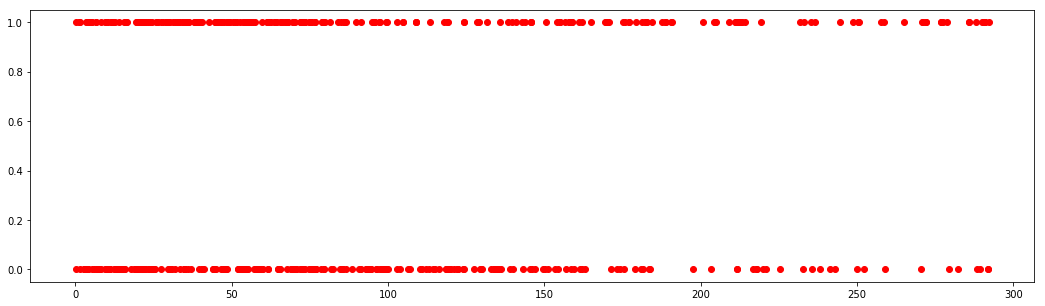

In [5]:
plt.figure(figsize=(18, 5))
start=1000
end=1500
plt.plot([i[0][0] for i in train_x[start:end]], [i[0] for i in train_y[start:end]], 'ro')
plt.show()

In [6]:
test_x, test_y=[], []
for i in range(6,7):
    data_x_part, data_y_part = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(i)+'_ID1_1L_GD.csv')
    window_y_part = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_part))
    
    for i in range(len(data_x_part)-timesteps):
        x=data_x_part[i:i+timesteps]
        y=window_y_part[i+timesteps]
        test_x.append(x)
        test_y.append(y)
        
# for i in range(6,7):
#     data_x_part, data_y_part = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(i)+'_ID1_1L_WC.csv')
#     window_y_part = read_xml('weallwalk/xml/T'+str(i)+'_ID1_GD.xml', len(data_x_part))
    
#     for i in range(len(data_x_part)-timesteps):
#         x=data_x_part[i:i+timesteps]
#         y=window_y_part[i+timesteps]
#         test_x.append(x)
#         test_y.append(y)
        
print(len(test_x))

2393


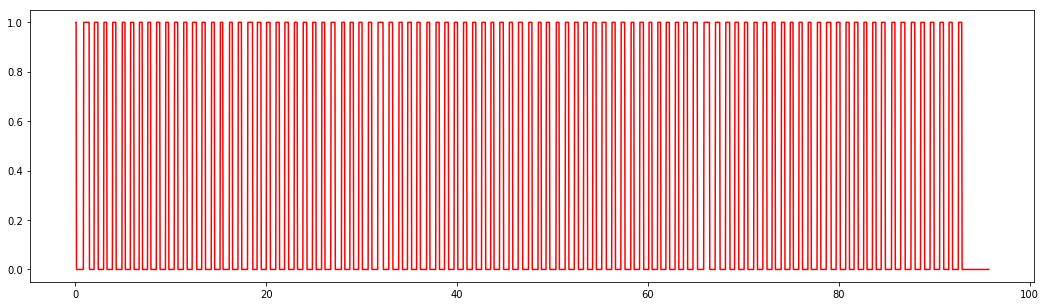

In [7]:
plt.figure(figsize=(18, 5))
plt.plot([i[0][0] for i in test_x], [i[0] for i in test_y], 'r')
# plt.plot([i[0][0] for i in test_x], [i[0] for i in test_logits], 'b')
plt.show()

In [8]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, state_is_tuple=True)
    return lstm_cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
        #'out':tf.Variable(tf.zeros([1]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

    logits = RNN(X, weights, biases)
    mean_train = tf.reduce_mean(X)
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

In [9]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
train_x.extend(train_x[0:batch_size])
train_y.extend(train_y[0:batch_size])
training_steps = 10001

In [10]:
config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(graph=graph, config=config) as session:
#     saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(training_steps):      
        feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
        batch_start += batch_size
        if(batch_start>=train_length):
            batch_start -=train_length
        _, l, predictions, m = session.run([optimizer, loss, logits,mean_train], feed_dict = feed_dict)
        if (step % 200 == 0):
            print('Loss at step %d: %f' % (step, l))
        if (step % 2000 == 0):
            saver.save(session, 'lstm_check/my-model-gpu-lr.ckpt', global_step=step)
    test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})

Initialized
Loss at step 0: 5.505631
Loss at step 200: 0.241391
Loss at step 400: 0.215365
Loss at step 600: 0.120445
Loss at step 800: 0.114797
Loss at step 1000: 0.116724
Loss at step 1200: 0.094453
Loss at step 1400: 0.084814
Loss at step 1600: 0.117666
Loss at step 1800: 0.093229
Loss at step 2000: 0.100762
Loss at step 2200: 0.121111
Loss at step 2400: 0.089238
Loss at step 2600: 0.090864
Loss at step 2800: 0.091264
Loss at step 3000: 0.068576
Loss at step 3200: 0.077548
Loss at step 3400: 0.081351
Loss at step 3600: 0.084270
Loss at step 3800: 0.072924
Loss at step 4000: 0.078403
Loss at step 4200: 0.086405
Loss at step 4400: 0.058869
Loss at step 4600: 0.068218
Loss at step 4800: 0.055640
Loss at step 5000: 0.050052
Loss at step 5200: 0.053301
Loss at step 5400: 0.045893
Loss at step 5600: 0.057759
Loss at step 5800: 0.052278
Loss at step 6000: 0.046002
Loss at step 6200: 0.042164
Loss at step 6400: 0.038107
Loss at step 6600: 0.037957
Loss at step 6800: 0.037478
Loss at step 70

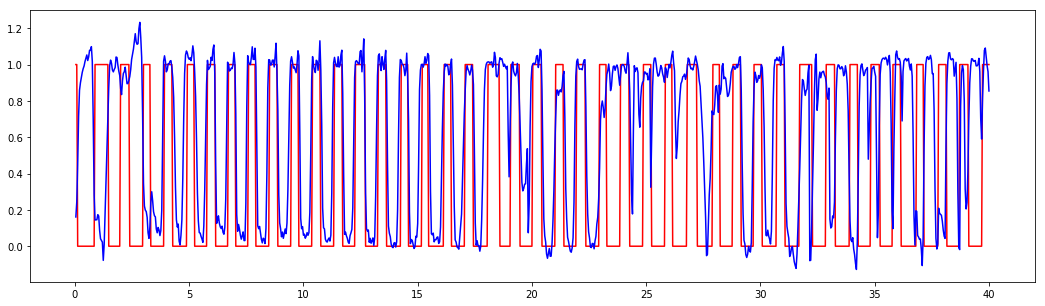

In [15]:
plt.figure(figsize=(18, 5))
start = 0
end =1000
plt.plot([i[0][0] for i in test_x[start:end]], [i[0] for i in test_y[start:end]], 'r')
plt.plot([i[0][0] for i in test_x[start:end]], [i[0] for i in test_logits[start:end]], 'b')
plt.show()

In [13]:
print(test_loss)

count = 0
for i in range(0, len(test_x)):
    if(test_y[i] == round(test_logits[i][0])):
        count += 1;
print(count/len(test_x))

0.627929
0.3301295445048057
